In [9]:
from src.aquastat_utils import get_aquastat, rename_aquastat_countries

# Import AQUASTAT
aquastat_df = get_aquastat()

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/../dat/fao_aquastat.csv already exists.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patches as mpatches
import matplotlib
import sys
import os
import numpy as np
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy import stats
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

# colormap for spatial plot
rb = LinearSegmentedColormap.from_list(
    "rb", [[0, 0, 153/255], [50/255, 150/255, 255/255], [1, 1, 1], [255/255, 102/255, 0], [153/255, 0, 0]], N=500
)


In [11]:
# Filter interesting variables
filter_for = ['waste', 'reuse', 'treatment']

filtered_columns = [column for column in aquastat_df.columns if any([x in column.lower() for x in filter_for])]
filtered_columns

['% of area equipped for irrigation by direct use of  treated municipal wastewater',
 '% of area equipped for irrigation by direct use of non-treated municipal wastewater',
 'Area equipped for irrigation by direct use of non-treated municipal wastewater ',
 'Area equipped for irrigation by direct use of not treated municipal wastewater',
 'Area equipped for irrigation by direct use of treated municipal wastewater',
 'Capacity of the municipal wastewater treatment facilities',
 'Collected municipal wastewater',
 'Direct use of not treated municipal wastewater for irrigation purposes',
 'Direct use of treated municipal wastewater',
 'Direct use of treated municipal wastewater for irrigation purposes',
 'Not treated municipal wastewater',
 'Not treated municipal wastewater discharged (secondary water)',
 'Number of municipal wastewater treatment facilities',
 'Produced municipal wastewater',
 'Treated municipal wastewater',
 'Treated municipal wastewater discharged (secondary water)']

We now have a list of variables related to waste water and treatment. Let's explore them.

In [12]:
# Get for each country the number of municipal wastewater treatment facilities

# Create a new dataframe with only the columns we are interested in
countries = aquastat_df['Country'].unique()
interesting_var = 'Number of municipal wastewater treatment facilities'

waste_df = aquastat_df[['Country', 'Year', interesting_var]]
waste_df = waste_df.dropna()  # Drop rows with missing values
#waste_df = waste_df.set_index('Country')  # Set the country as index
waste_df = waste_df.sort_values(by=interesting_var, ascending=False)  # Sort by number of facilities

waste_df

Variable,Country,Year,Number of municipal wastewater treatment facilities
10127,United States of America,2004,16583.0
10126,United States of America,2003,16501.0
10125,United States of America,2002,16419.0
10124,United States of America,2001,16337.0
10123,United States of America,2000,16255.0
...,...,...,...
9710,Turkmenistan,2015,1.0
9711,Turkmenistan,2016,1.0
9712,Turkmenistan,2017,1.0
9713,Turkmenistan,2018,1.0


The total number is not very interesting to us so lets look at facilities per capita.
We dont want to look at to small numbers so per 1000 people seems appropriate

In [13]:
'''Get facilities per n citizens'''
waste_df['Total population'] = aquastat_df['Total population']
n = 1000
waste_df[f'{interesting_var} per {n} citizens'] = (waste_df[interesting_var] / waste_df['Total population']) * n
waste_df

Variable,Country,Year,Number of municipal wastewater treatment facilities,Total population,Number of municipal wastewater treatment facilities per 1000 citizens
10127,United States of America,2004,16583.0,292354.658,56.722202
10126,United States of America,2003,16501.0,289815.562,56.936211
10125,United States of America,2002,16419.0,287279.318,57.153436
10124,United States of America,2001,16337.0,284607.993,57.401761
10123,United States of America,2000,16255.0,281710.909,57.700996
...,...,...,...,...,...
9710,Turkmenistan,2015,1.0,5565.287,0.179685
9711,Turkmenistan,2016,1.0,5662.368,0.176605
9712,Turkmenistan,2017,1.0,5757.667,0.173681
9713,Turkmenistan,2018,1.0,5850.901,0.170914


Plot the development of the number of facilities over time

In [14]:
'''Just for testing'''
sns.scatterplot(data= waste_df[waste_df['Country'] == 'Germany'], x='Year', y='Number of municipal wastewater treatment facilities')

<Axes: xlabel='Year', ylabel='Number of municipal wastewater treatment facilities'>

In [15]:
import geopandas as gpd
from src.utils import to_dat_path

def get_slope(series):
    x = series.index
    y = series.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope

def plot_coeffs(data, variable):
    '''get slopes'''
    # Pivot the DataFrame to have years as the index and countries as columns
    df_pivot = data.pivot(index='Year', columns='Country', values=variable).dropna()
    
    # Apply the function to calculate slope for each country
    slopes = df_pivot.apply(get_slope)
    
    # Convert the results to a DataFrame or leave it as a Series based on your preference
    slopes_df = slopes.reset_index(name='Slope')   
    
    '''plot'''
    world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
    
    # Rename the countries to match the names in the world dataframe
    rename_aquastat_countries(slopes_df)
    merged = world.set_index('SOVEREIGNT').join(slopes_df.set_index('Country'))
    merged['Slope'] = merged['Slope']
    
    category_colors = {
        'coef < -1': 'red',
        '-1 <= coef < 0': 'orange',
        '0 <= coef < 1': 'green',
        'coef > 1': 'aqua'
    }
    
    bins = [-5, -1, 0, 1, 5]
    labels = list(category_colors.keys())
    merged['Slope_binned'] = pd.cut(merged['Slope'], bins=bins, labels=labels)
    
    # Create a color list in the order of bins
    color_list = [category_colors[label] for label in labels]
    
    # Create a ListedColormap with your color list
    cmap = matplotlib.colors.ListedColormap(color_list)
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged.plot(
        column='Slope_binned',
        ax=ax, legend=True,
        missing_kwds={"color": "grey", "label": "No Data",},
        cmap=cmap
    )
    plt.show()

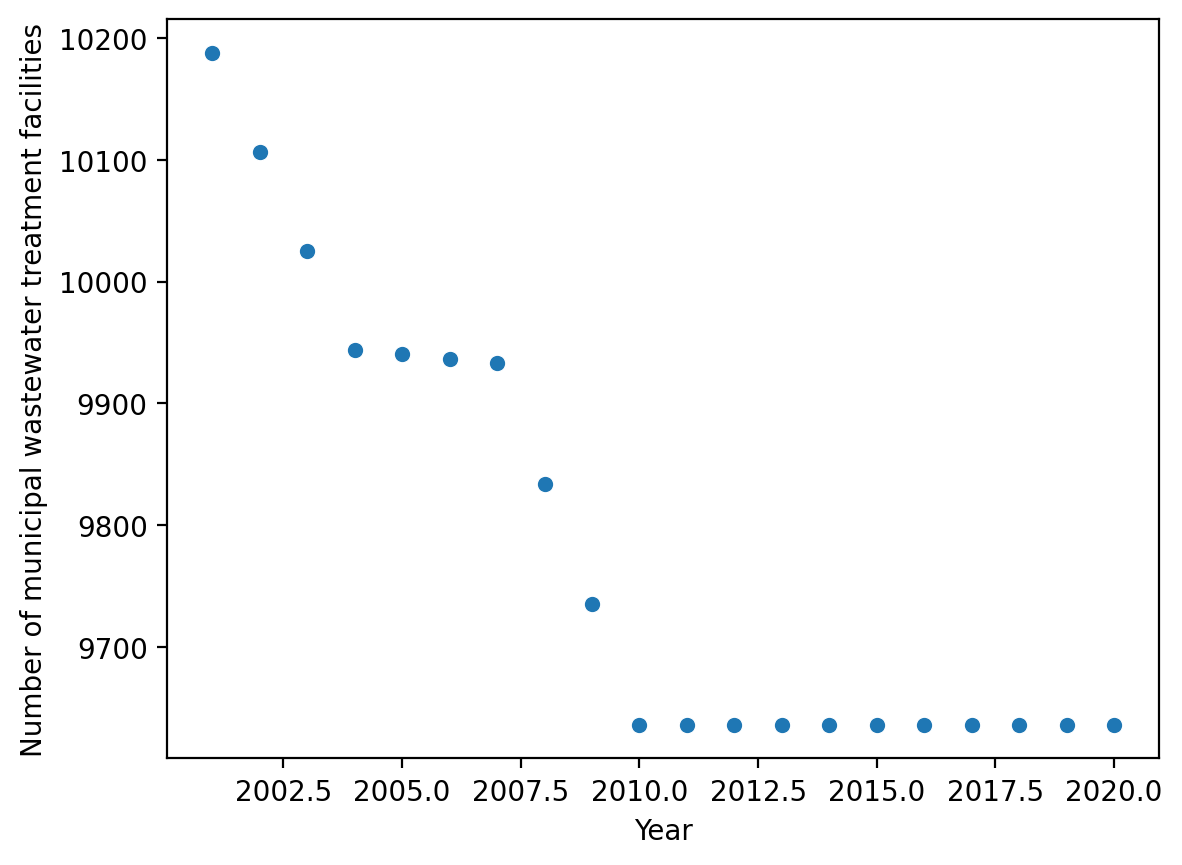

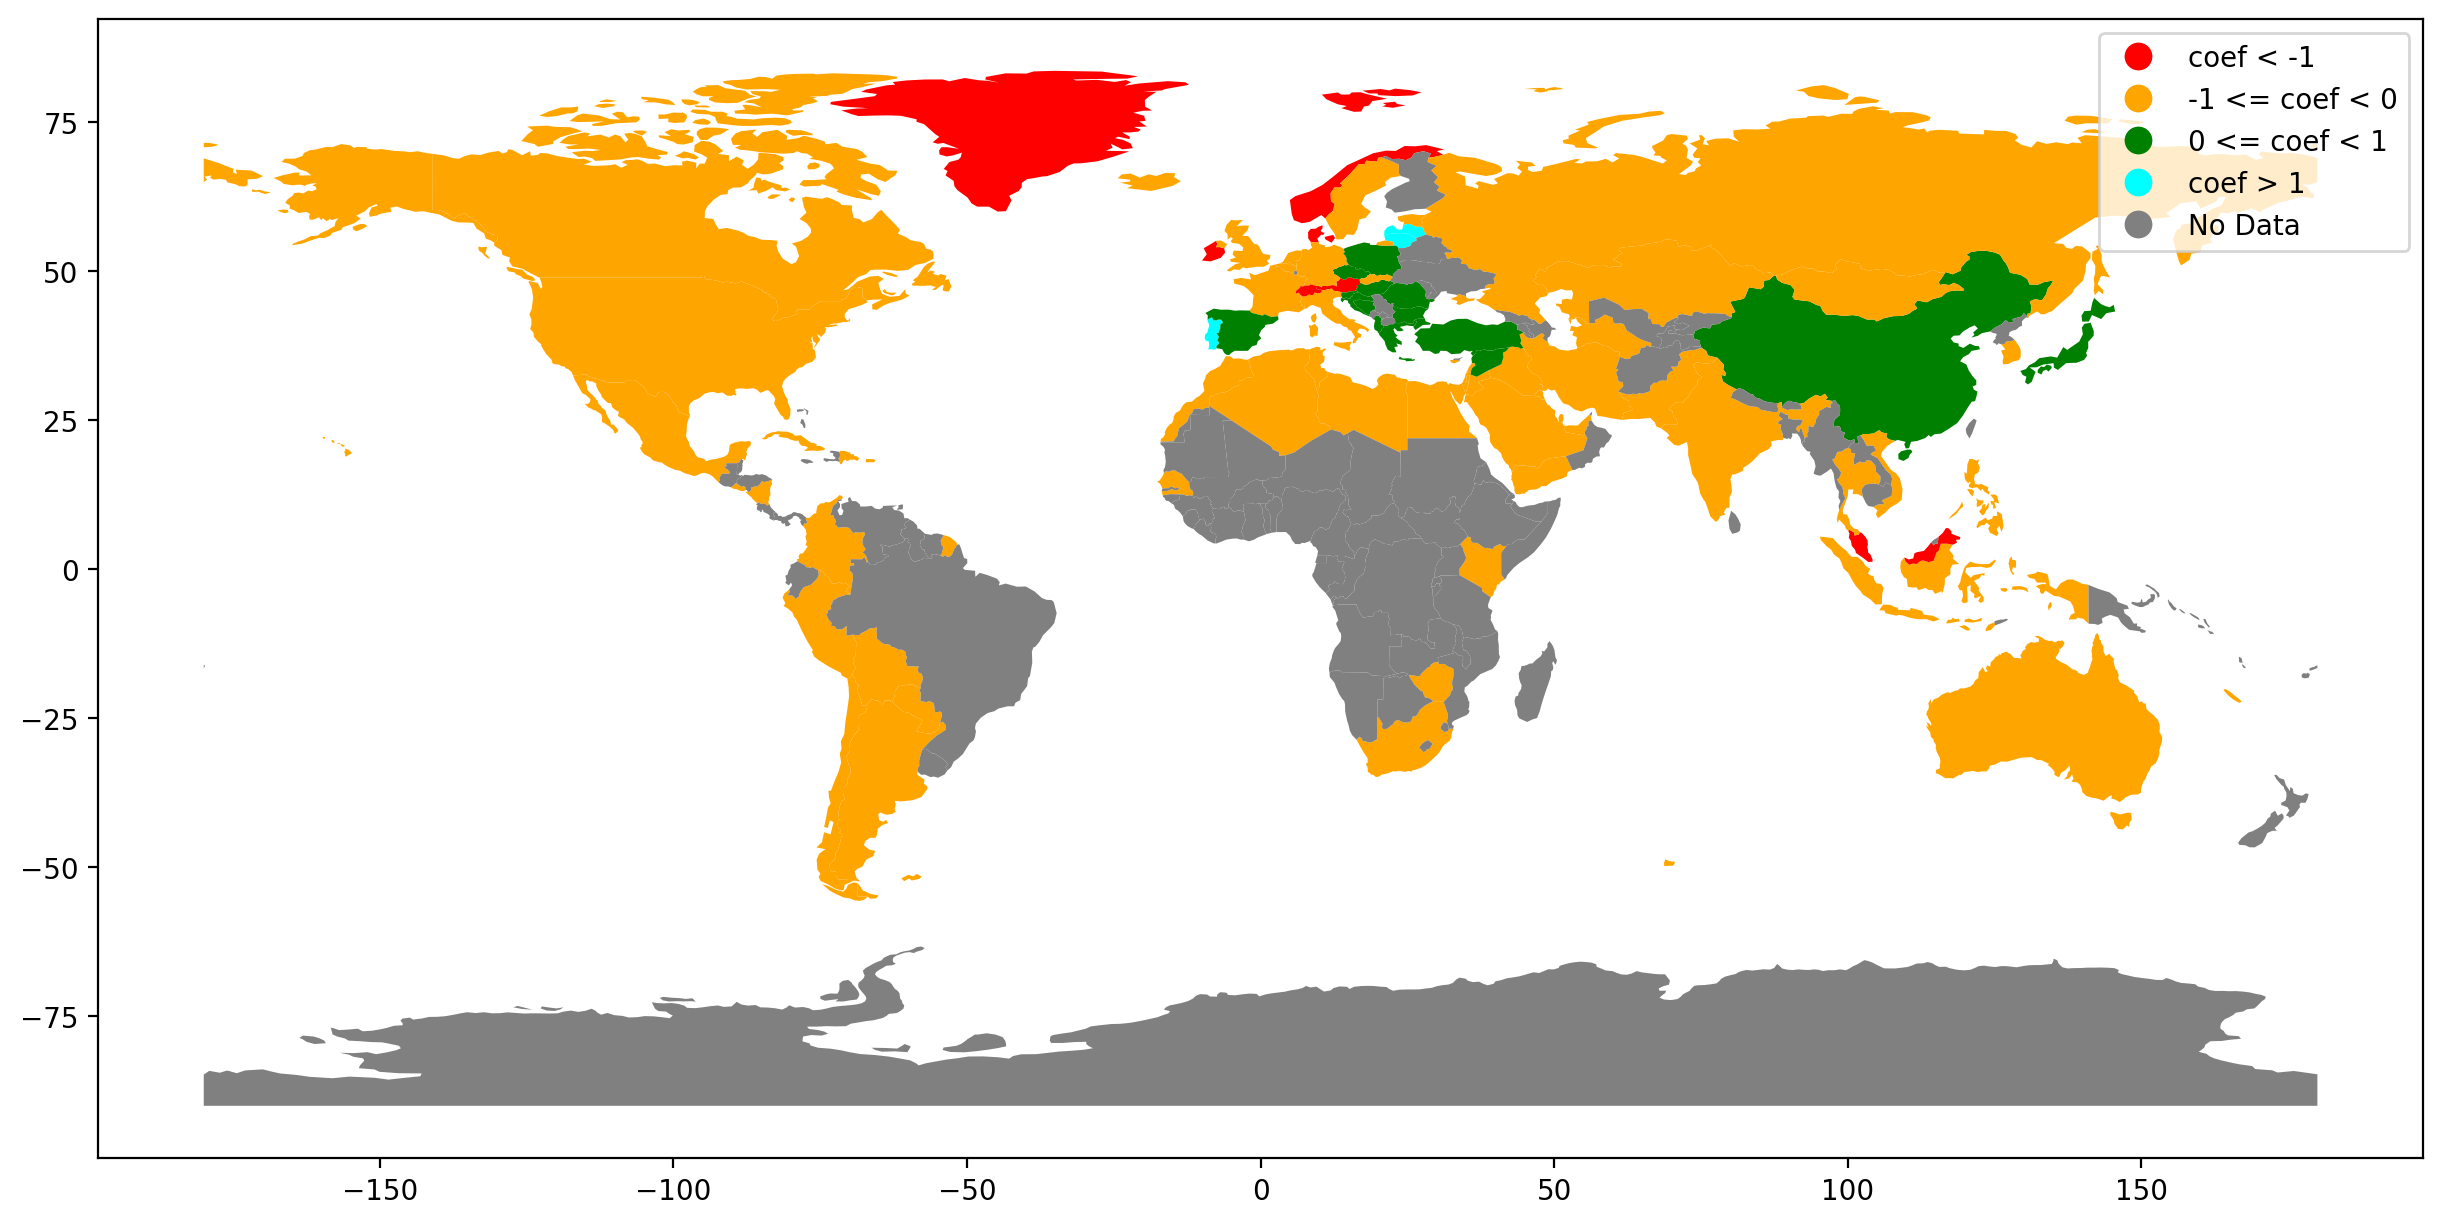

In [16]:
plot_coeffs(waste_df, 'Number of municipal wastewater treatment facilities per 1000 citizens')

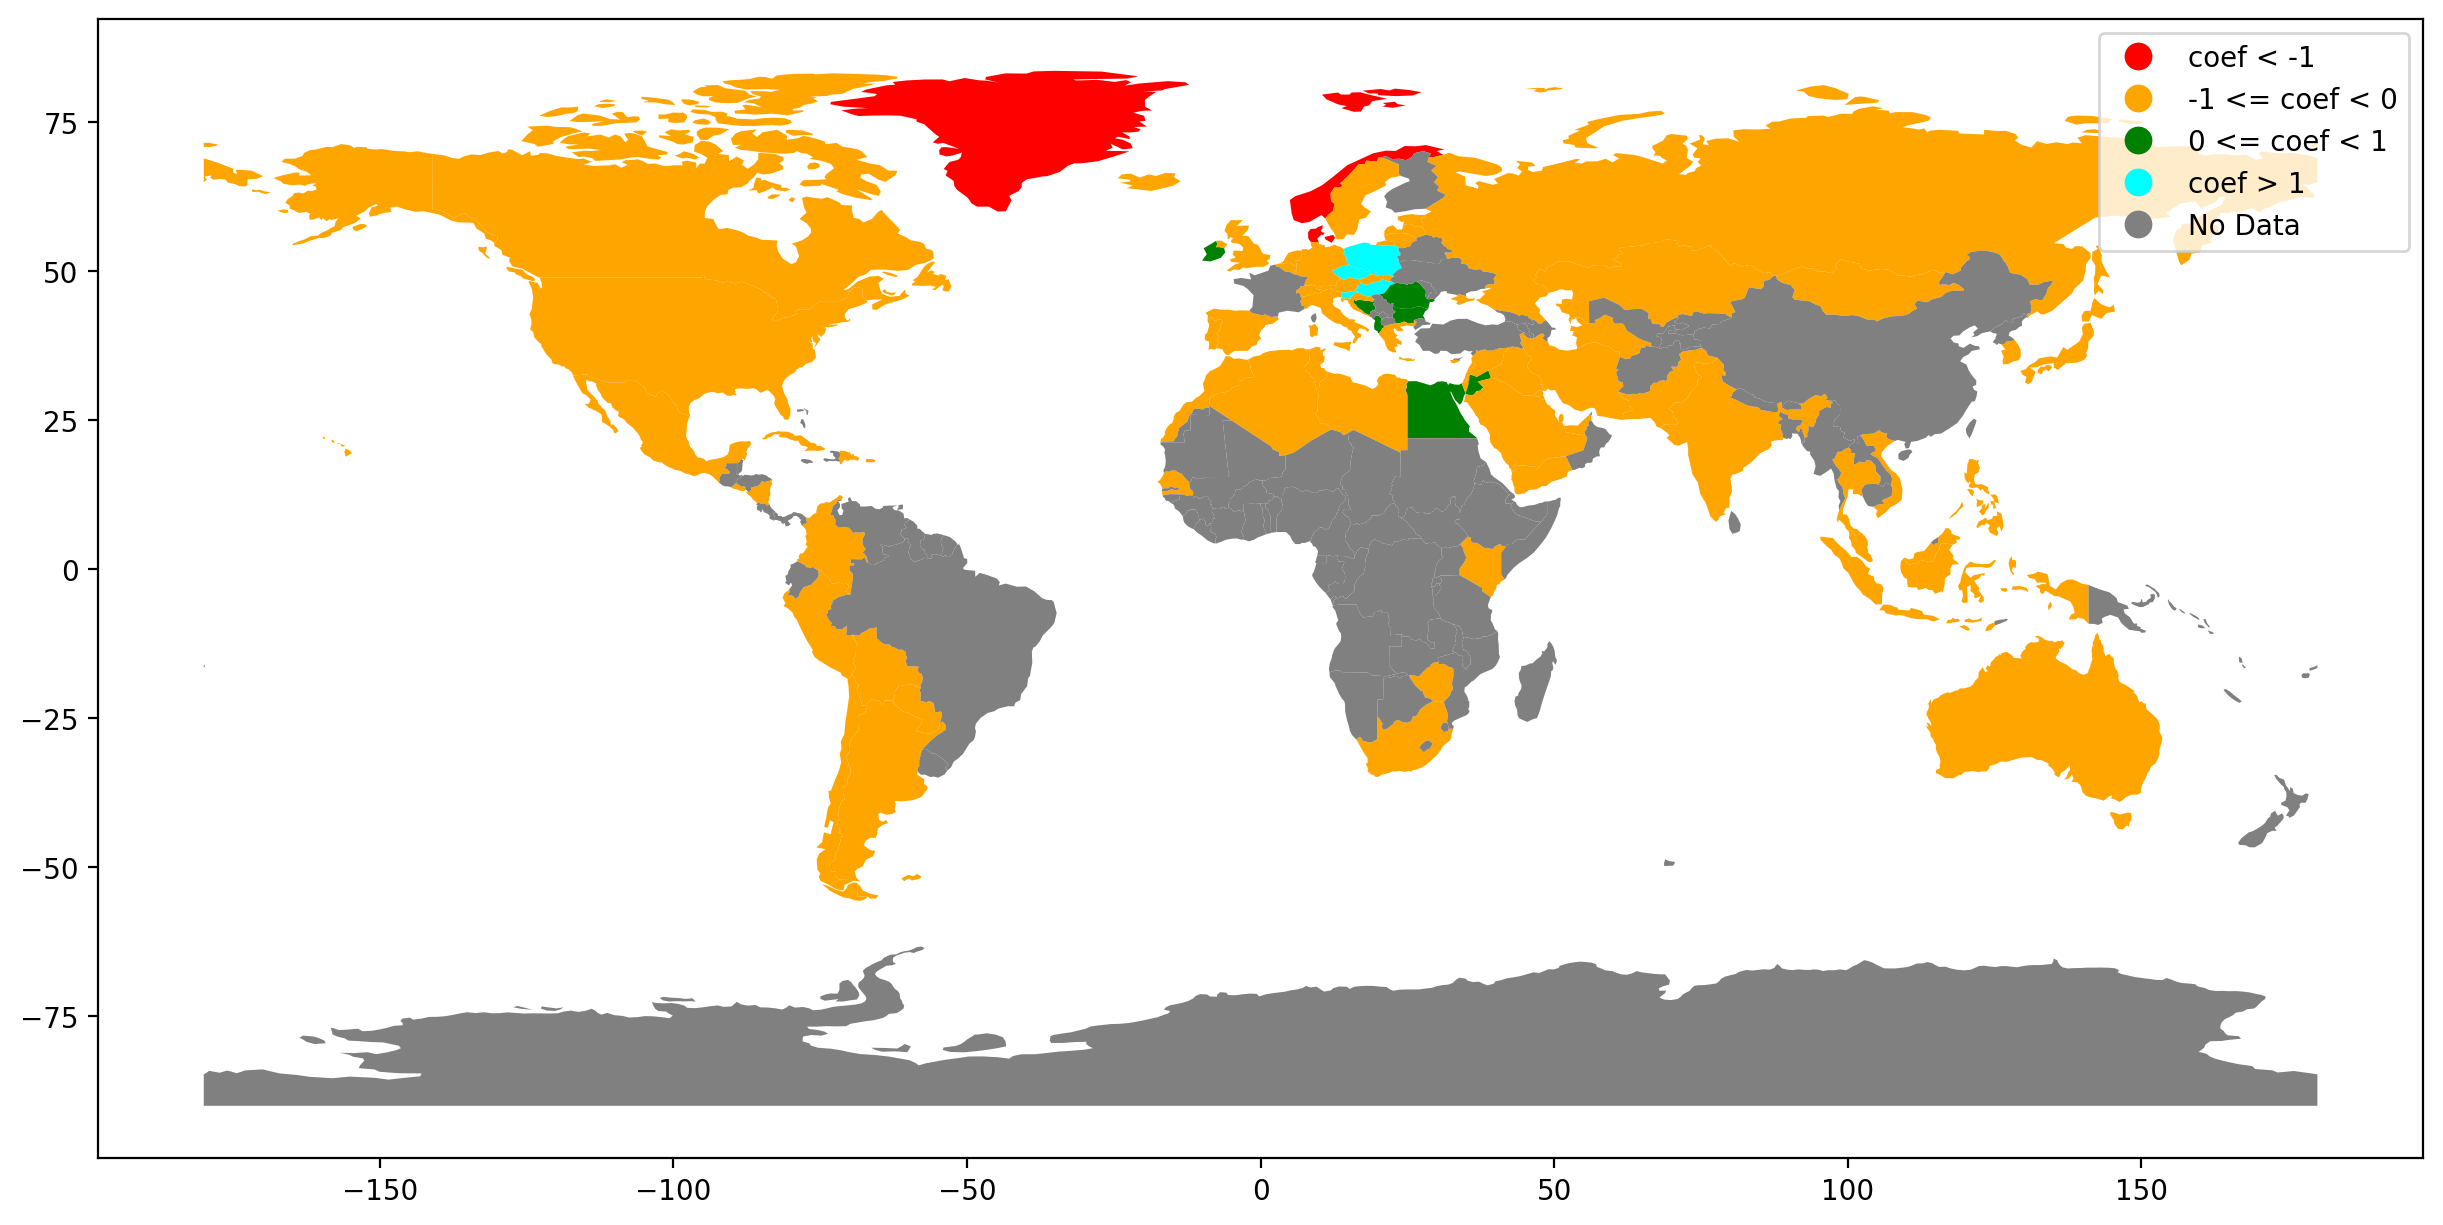

In [17]:
plot_coeffs(waste_df, 'Number of municipal wastewater treatment facilities')


# TODOS

- Plot the development of the number of facilities over time
- Plot the number of facilities per capita
- [HydroWASTE](https://www.hydrosheds.org/products/hydrowaste):
    - Download the data
    - Explore the data:
        - A nice map of the world
        - The more facilities, the more water is treated?
            - Plot the number of facilities against the water withdrawal
            - What about the countries that face water scarcity?
                - Plot the number of facilities against the water scarcity: facility / water scarcity -> should be normalized by water stress (water scarcity / water availability)  